In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from preprocessing import TrainDataset



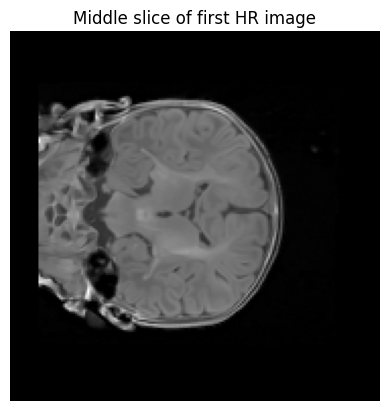

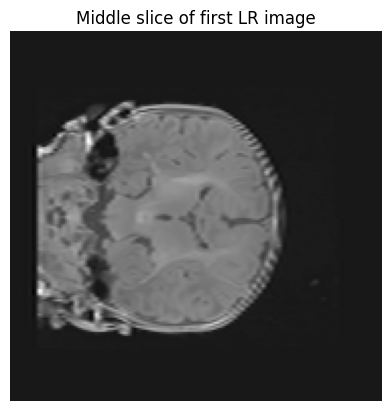

In [ ]:
csv_file = "/Users/al1612le/T1-HR-LR-pairs/t1_hr_lr_pairs.csv" 
img_dir = "/Users/al1612le/T1-HR-LR-pairs"  

train_dataset = TrainDataset(csv_file, img_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

data_iter = iter(train_loader)
HR_imgs, LR_imgs = next(data_iter)

plt.imshow(HR_imgs[0, :, HR_imgs.shape[2] // 2, :], cmap='gray')
plt.title("Middle slice of first HR image")
plt.axis('off')
plt.show()

plt.imshow(LR_imgs[0, :, LR_imgs.shape[2] // 2, :], cmap='gray')
plt.title("Middle slice of first LR image")
plt.axis('off')
plt.show()

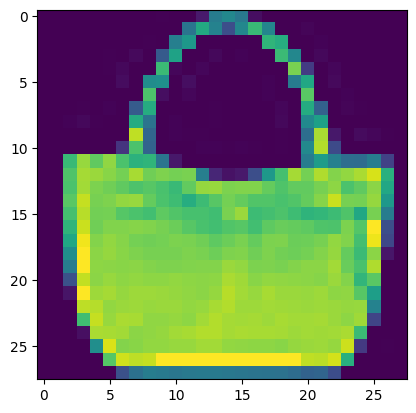

In [27]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

img, lbl = training_data[100]
plt.imshow(img[0,:,:])

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299552  [   64/60000]
loss: 2.286955  [ 6464/60000]
loss: 2.270216  [12864/60000]
loss: 2.269652  [19264/60000]
loss: 2.248631  [25664/60000]
loss: 2.224785  [32064/60000]
loss: 2.222852  [38464/60000]
loss: 2.198638  [44864/60000]
loss: 2.199477  [51264/60000]
loss: 2.163605  [57664/60000]
Test Error: 
 Accuracy: 47.7%, Avg loss: 2.158200 

Epoch 2
-------------------------------
loss: 2.169654  [   64/60000]
loss: 2.156301  [ 6464/60000]
loss: 2.101021  [12864/60000]
loss: 2.114022  [19264/60000]
loss: 2.060631  [25664/60000]
loss: 2.017131  [32064/60000]
loss: 2.020305  [38464/60000]
loss: 1.959827  [44864/60000]
loss: 1.961995  [51264/60000]
loss: 1.880445  [57664/60000]
Test Error: 
 Accuracy: 61.3%, Avg loss: 1.881777 

Epoch 3
-------------------------------
loss: 1.919569  [   64/60000]
loss: 1.885984  [ 6464/60000]
loss: 1.770330  [12864/60000]
loss: 1.797426  [19264/60000]
loss: 1.694861  [25664/60000]
loss: 1.660028  [32064/600